In [3]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP

In [4]:
torch.cuda.is_available()

True

In [5]:
from clsar.dataset import LSSNS # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures # feature
from clsar.model import ACANet_PNA, get_deg # model
from clsar.model.loss import ACALoss, get_best_cliff

In [6]:
dataset_name = 'pkci'
Dataset =  LSSNS # MoleculeNet
epochs = 800

pre_transform = Gen115AtomFeatures()
in_channels = 115
path = '/tmp/mydata'

dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

In [7]:
batch_size = 128

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
deg = get_deg(train_dataset)
#cliff_lower, cliff_upper, n = get_best_cliff(train_dataset.data.y)
cliff_lower, cliff_upper = 1.0, 1.0

In [9]:

def train(train_loader):
    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

## Cliff Awaness factor: 1.0

In [10]:
## model HPs
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1, 
            'edge_dim':10, 'num_layers':2, 'dropout_p':0.0, 'batch_norms':None}


model = ACANet_PNA(**pub_args, aggregators=['mean', 'min', 'max', 'sum'],
                     scalers=['identity', 'amplification', 'attenuation'] ,
                     deg=deg).to(device)
                   
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)

aca_loss = ACALoss(alpha=1.0, cliff_lower = cliff_lower, cliff_upper = cliff_upper)


history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
          f'n_triplets: {n_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'n_triplets': n_triplets, 'n_pos_triplets':n_pos_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df1 = pd.DataFrame(history)

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 7.4775 tsm_loss: 2.5764 reg_loss: 4.9012 n_triplets: 4850;  Val: 5.2177 Test: 4.7951
Epoch: 002, Loss: 7.3626 tsm_loss: 2.5757 reg_loss: 4.7869 n_triplets: 4850;  Val: 5.1121 Test: 4.6873
Epoch: 003, Loss: 7.2514 tsm_loss: 2.5733 reg_loss: 4.6781 n_triplets: 4850;  Val: 4.9954 Test: 4.5683
Epoch: 004, Loss: 7.1265 tsm_loss: 2.5691 reg_loss: 4.5574 n_triplets: 4850;  Val: 4.8678 Test: 4.4381
Epoch: 005, Loss: 6.9893 tsm_loss: 2.5641 reg_loss: 4.4252 n_triplets: 4850;  Val: 4.7135 Test: 4.2804
Epoch: 006, Loss: 6.8250 tsm_loss: 2.5599 reg_loss: 4.2651 n_triplets: 4850;  Val: 4.5255 Test: 4.0882
Epoch: 007, Loss: 6.6232 tsm_loss: 2.5543 reg_loss: 4.0689 n_triplets: 4850;  Val: 4.2966 Test: 3.8540
Epoch: 008, Loss: 6.3730 tsm_loss: 2.5447 reg_loss: 3.8283 n_triplets: 4850;  Val: 4.0150 Test: 3.5655
Epoch: 009, Loss: 6.0652 tsm_loss: 2.5361 reg_loss: 3.5292 n_triplets: 4850;  Val: 3.6737 Test: 3.2152
Epoch: 010, Loss: 5.6899 tsm_loss: 2.5287 reg_loss: 3.1612 n_triplets: 48

## Cliff Awaness factor: 0

In [11]:
## model HPs
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1, 
            'edge_dim':10, 'num_layers':2, 'dropout_p':0.0, 'batch_norms':None}


model = ACANet_PNA(**pub_args, aggregators=['mean', 'min', 'max', 'sum'],
                     scalers=['identity', 'amplification', 'attenuation'] ,
                     deg=deg).to(device)
                   
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)

aca_loss = ACALoss(alpha=0.0, cliff_lower = cliff_lower, cliff_upper = cliff_upper)

history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
          f'n_triplets: {n_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'n_triplets': n_triplets, 'n_pos_triplets':n_pos_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df2 = pd.DataFrame(history)

Epoch: 001, Loss: 4.8650 tsm_loss: 2.5736 reg_loss: 4.8650 n_triplets: 4850;  Val: 5.1644 Test: 4.7401
Epoch: 002, Loss: 4.7305 tsm_loss: 2.5725 reg_loss: 4.7305 n_triplets: 4850;  Val: 5.0463 Test: 4.6192
Epoch: 003, Loss: 4.6091 tsm_loss: 2.5705 reg_loss: 4.6091 n_triplets: 4850;  Val: 4.9159 Test: 4.4858
Epoch: 004, Loss: 4.4746 tsm_loss: 2.5673 reg_loss: 4.4746 n_triplets: 4850;  Val: 4.7606 Test: 4.3268
Epoch: 005, Loss: 4.3134 tsm_loss: 2.5636 reg_loss: 4.3134 n_triplets: 4850;  Val: 4.5704 Test: 4.1320


/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 006, Loss: 4.1150 tsm_loss: 2.5602 reg_loss: 4.1150 n_triplets: 4850;  Val: 4.3384 Test: 3.8943
Epoch: 007, Loss: 3.8712 tsm_loss: 2.5565 reg_loss: 3.8712 n_triplets: 4850;  Val: 4.0514 Test: 3.5998
Epoch: 008, Loss: 3.5668 tsm_loss: 2.5538 reg_loss: 3.5668 n_triplets: 4850;  Val: 3.6984 Test: 3.2374
Epoch: 009, Loss: 3.1865 tsm_loss: 2.5501 reg_loss: 3.1865 n_triplets: 4850;  Val: 3.2730 Test: 2.8001
Epoch: 010, Loss: 2.7153 tsm_loss: 2.5454 reg_loss: 2.7153 n_triplets: 4850;  Val: 2.7768 Test: 2.2906
Epoch: 011, Loss: 2.1368 tsm_loss: 2.5420 reg_loss: 2.1368 n_triplets: 4850;  Val: 2.2301 Test: 1.7404
Epoch: 012, Loss: 1.6320 tsm_loss: 2.5366 reg_loss: 1.6320 n_triplets: 4850;  Val: 1.7720 Test: 1.3477
Epoch: 013, Loss: 1.5272 tsm_loss: 2.5418 reg_loss: 1.5272 n_triplets: 4850;  Val: 1.6740 Test: 1.4728
Epoch: 014, Loss: 1.6498 tsm_loss: 2.5449 reg_loss: 1.6498 n_triplets: 4850;  Val: 1.8934 Test: 1.8571
Epoch: 015, Loss: 1.8895 tsm_loss: 2.5469 reg_loss: 1.8895 n_triplets: 48

<AxesSubplot:>

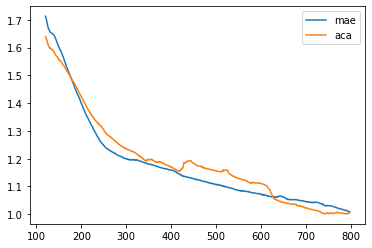

In [12]:
df2.val_rmse.to_frame(name = 'mae').join(df1.val_rmse.to_frame(name = 'aca')).rolling(100).mean().iloc[120:].plot()

<AxesSubplot:>

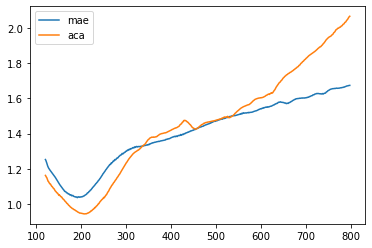

In [13]:
df2.test_rmse.to_frame(name = 'mae').join(df1.test_rmse.to_frame(name = 'aca')).rolling(100).mean().iloc[120:].plot()

<AxesSubplot:>

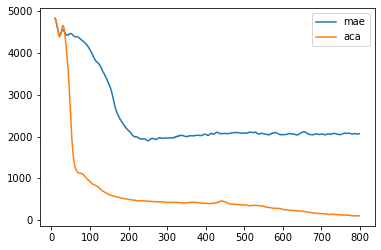

In [14]:
df2.n_pos_triplets.to_frame(name = 'mae').join(df1.n_pos_triplets.to_frame(name = 'aca')).rolling(10).mean().plot()

<AxesSubplot:>

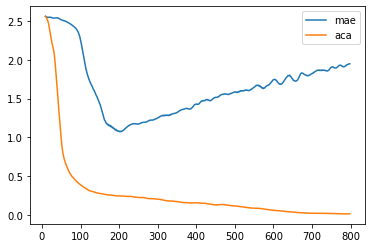

In [16]:
df2.train_triplet_loss.to_frame(name = 'mae').join(df1.train_triplet_loss.to_frame(name = 'aca')).rolling(10).mean().plot()

In [17]:
df2

,Epoch,train_loss,train_triplet_loss,train_mae_loss,val_rmse,test_rmse,n_triplets,n_pos_triplets
0,1,4.864976,2.573606,4.864976,5.164360,4.740069,4850,4850
1,2,4.730454,2.572472,4.730454,5.046327,4.619194,4850,4850
2,3,4.609133,2.570541,4.609133,4.915945,4.485767,4850,4850
3,4,4.474616,2.567310,4.474616,4.760585,4.326793,4850,4850
4,5,4.313384,2.563564,4.313384,4.570406,4.131951,4850,4847
...,...,...,...,...,...,...,...,...
794,795,0.376143,1.947961,0.376143,0.968822,1.704200,4850,2073
795,796,0.366412,1.947294,0.366412,0.918146,1.641606,4850,2076
796,797,0.389148,1.962268,0.389148,0.971809,1.703160,4850,2086
797,798,0.349329,1.941971,0.349329,0.980839,1.709562,4850,2076


In [18]:
df1

,Epoch,train_loss,train_triplet_loss,train_mae_loss,val_rmse,test_rmse,n_triplets,n_pos_triplets
0,1,7.477543,2.576390,4.901153,5.217718,4.795131,4850,4850
1,2,7.362611,2.575673,4.786938,5.112053,4.687346,4850,4850
2,3,7.251392,2.573260,4.678132,4.995447,4.568262,4850,4850
3,4,7.126503,2.569082,4.557421,4.867803,4.438085,4850,4850
4,5,6.989290,2.564102,4.425188,4.713474,4.280449,4850,4847
...,...,...,...,...,...,...,...,...
794,795,0.416985,0.013350,0.403634,0.976383,2.313274,4850,97
795,796,0.198438,0.014192,0.184247,1.015461,2.415059,4850,114
796,797,0.430535,0.016484,0.414051,0.974598,2.245221,4850,122
797,798,0.180532,0.013850,0.166681,1.077204,2.124974,4850,103
